# SLIP Optimization Experimentation

Experimenting with optimizing SLIP models.

- Paper "Tuned Fitness Landscapes for Benchmarking Model-Guided Protein Design" [Thomas et al](https://www.biorxiv.org/content/10.1101/2022.10.28.514293v1)
- Code: https://github.com/google-research/slip


### Imports

In [1]:
import os
import random
import collections

from tqdm import tqdm 

import numpy as np
import pandas as pd
import scipy.stats
import einops

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

In [2]:
import xgboost as xgb

In [3]:
os.chdir(os.path.expanduser('~/repos/diffusion-guidance'))

### SLIP Protein Landscapes

In [6]:
from slip import potts_model

In [7]:
pdb = '3er7'  # 3bfo, 3gfb, 5hu4, 3my2

landscape = potts_model.load_from_mogwai_npz(
    f'slip/data/{pdb}_1_A_model_state_dict.npz', coupling_scale=1.0)

In [ ]:
landscape

In [6]:
all_singles = sampling.get_all_single_mutants(landscape.wildtype_sequence, landscape.vocab_size)
random_doubles = sampling.sample_within_hamming_radius(landscape.wildtype_sequence, 1000, landscape.vocab_size, 2, 2)

In [7]:
singles_df = experiment.get_fitness_df(all_singles, landscape.evaluate, landscape.wildtype_sequence)
singles_df['name'] = 'singles'

random_doubles_df = experiment.get_fitness_df(random_doubles, landscape.evaluate, landscape.wildtype_sequence)
random_doubles_df['name'] = 'random_doubles'

df = pd.concat([singles_df, random_doubles_df], ignore_index=True)

In [ ]:
df

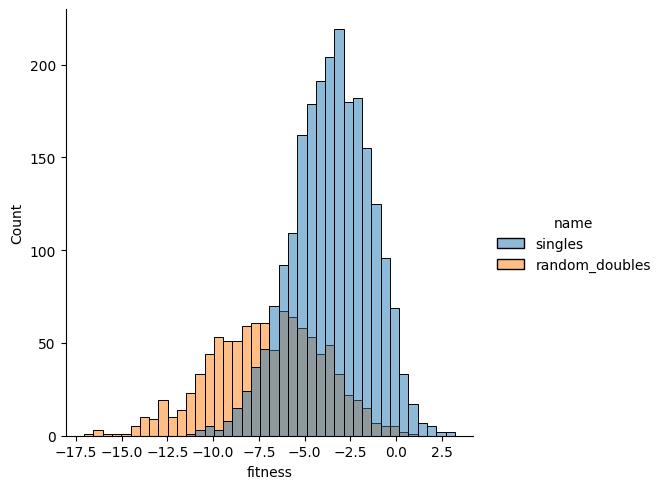

In [9]:
sns.displot(data=df, x='fitness', hue='name')

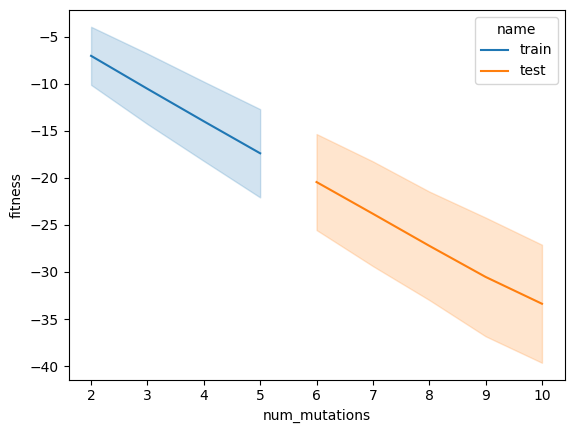

In [460]:
sample = sampling.sample_within_hamming_radius(landscape.wildtype_sequence, 10000, landscape.vocab_size, 2, 10)
df = experiment.get_fitness_df(sample, landscape.evaluate, landscape.wildtype_sequence)

train_df, test_df = experiment.get_distance_split_df(df, landscape.wildtype_sequence, 5)
train_df['name'] = 'train'
test_df['name'] = 'test'

df = pd.concat([train_df, test_df], ignore_index=True)
sns.lineplot(data=df, x='num_mutations', y='fitness', errorbar='sd', hue='name')
pass

In [461]:
x_train = np.array(df[df.name == "train"].sequence.values.tolist())
y_train = np.array(df[df.name == "train"].fitness)

In [462]:
x_test = np.array(df[df.name == "test"].sequence.values.tolist())
y_test = np.array(df[df.name == "test"].fitness)

### Landscape Creation

In [463]:
pdb = ['3er7', '3bfo', '3gfb', '5hu4', '3my2'][0]

landscape = potts_model.load_from_mogwai_npz(
    f'slip/data/{pdb}_1_A_model_state_dict.npz',
    coupling_scale=2.0)

In [464]:
sample = sampling.sample_within_hamming_radius(
    landscape.wildtype_sequence,
    num_samples=10000,
    vocab_size=landscape.vocab_size,
    min_mutations=2,
    max_mutations=10)

df = experiment.get_fitness_df(sample, landscape.evaluate, landscape.wildtype_sequence)
train_df, test_df = experiment.get_distance_split_df(df, landscape.wildtype_sequence, distance_threshold=5)
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])

In [465]:
x_train = np.array(df[df.split == "train"].sequence.values.tolist())
y_train = np.array(df[df.split == "train"].fitness)

x_test = np.array(df[df.split == "test"].sequence.values.tolist())
y_test = np.array(df[df.split == "test"].fitness)

print('Train size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Train size: 4472
Test size: 5528


### PyTorch Models

In [466]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [467]:
class ResidualBlock(nn.Module):

    def __init__(self, num_channels: int, hidden_channels: int):
        super().__init__()
        self.conv1 = nn.Conv1d(num_channels, hidden_channels, kernel_size=1, padding='same')
        self.conv3 = nn.Conv1d(num_channels, hidden_channels, kernel_size=3, padding='same')
        self.conv5 = nn.Conv1d(num_channels, hidden_channels, kernel_size=5, padding='same')
        self.conv7 = nn.Conv1d(num_channels, hidden_channels, kernel_size=7, padding='same')
        self.conv_combine = nn.Conv1d(4 * hidden_channels, num_channels, kernel_size=1, padding='same')

        self.layer_norm_hidden = nn.LayerNorm(4 * hidden_channels)
        self.layer_norm = nn.LayerNorm(num_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = einops.rearrange(x, 'b l c -> b c l')
        out1 = self.conv1(x_)
        out3 = self.conv3(x_)
        out5 = self.conv5(x_)
        out7 = self.conv7(x_)
        hidden = torch.concat([out1, out3, out5, out7], axis=1)
        hidden = self.layer_norm_hidden(hidden.permute(0, 2, 1)).permute(0, 2, 1)
        hidden = F.gelu(hidden)

        out = F.gelu(self.layer_norm(self.conv_combine(hidden).permute(0, 2, 1)))

        return x + out

class Head(nn.Module):

    def __init__(self, in_features: int, num_output: int, num_hidden: int = 128):
        super().__init__()
        self.linear0 = nn.Linear(in_features, num_hidden)
        self.linear1 = nn.Linear(num_hidden, num_output)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = F.gelu(self.linear0(x))
        return self.linear1(z)

class ResNet(nn.Module):

    def __init__(self, in_channels: int, num_blocks: int, hidden_channels: int):
        super().__init__()
        self.in_channels = in_channels
        self.blocks = nn.ModuleList([
            ResidualBlock(in_channels, hidden_channels=hidden_channels)
            for _ in range(num_blocks)
        ])
        self.head = Head(in_features=in_channels, num_output=1)
    
    def forward(self, toknes: torch.Tensor) -> torch.Tensor:
        x = F.one_hot(toknes, num_classes=self.in_channels).to(torch.float32)
        for block in self.blocks:
            x = block(x)
        return self.head(x.mean(axis=1))[:, 0]

In [468]:
class LinearModel(nn.Module):

    def __init__(self, length: int, vocab_size: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.linear = nn.Linear(length * vocab_size, 1)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        x = F.one_hot(tokens, num_classes=self.vocab_size)
        x = x.to(torch.float32).to(tokens.device)
        x = einops.rearrange(x, 'b l v -> b (l v)')
        return self.linear(x)[:, 0]

In [469]:
model = ResNet(in_channels=20, num_blocks=2, hidden_channels=32)
# model  = LinearModel(length=landscape.length, vocab_size=landscape.vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Parameter count:', parameter_count)

Parameter count: 29305


In [470]:
def fit_pytorch_model(model, df: pd.DataFrame) -> nn.Module:
    df_train = df[df.split == "train"]
    df_test = df[df.split == "test"]

    tokens_train = torch.tensor(df_train.sequence.tolist(), dtype=torch.long).to(device)
    y_train = torch.tensor(df_train.fitness.values).to(device)

    tokens_test = torch.tensor(df_test.sequence.tolist(), dtype=torch.long).to(device)
    y_test = torch.tensor(df_test.fitness.values).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.6)

    pbar = tqdm(range(1000))
    for i in pbar:
        optimizer.zero_grad()
        preds = model(tokens_train)
        loss = torch.nn.SmoothL1Loss(beta=1.0)(preds, y_train)

        loss.backward()
        optimizer.step()

        train_pred = model(tokens_train).to('cpu').detach().numpy()
        test_pred =  model(tokens_test).to('cpu').detach().numpy()

        wandb.log({
            'loss': loss,
            'train_spearman': scipy.stats.spearmanr(y_train.to('cpu').detach().numpy(), train_pred).correlation,
            'test_spearman': scipy.stats.spearmanr(y_test.to('cpu').detach().numpy(), test_pred).correlation,
            'train_l2': np.square(y_train.to('cpu').detach().numpy() - train_pred).mean(),
            'test_l2': np.square(y_test.to('cpu').detach().numpy() - test_pred).mean(),
        })

    wand.finish()
    return model

In [471]:
wandb.init(
        project="sequence-design",
        name="simple-fit",
        config={
            "learning_rate": 0.02,
        }
    )

fit_pytorch_model(model, df)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▇▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁█▆▄▄▃▃▃▂▂▂▂▂▂▂
test_l2,▄▂▂▂▂▂▂▁▁▂▂▁▂▂▂▁▂▄▁▂▂▁▁▂▂▂█▄▃▃▂▂▂▂▂▁▂▁▂▂
test_spearman,▅█▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▆▅▅▅▁▄▇▇█████████▇
train_l2,▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁█▄▃▃▂▂▂▂▂▂▁▂▁▁
train_spearman,▅▆▇▇▇▇▇██████████▇████████▁▃▅▆▇▇▇▇▇▇▇▇▇█
loss,0.47094
test_l2,83.95394
test_spearman,0.65043
train_l2,1.83137
train_spearman,0.98253


100%|████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.63it/s]


ResNet(
  (blocks): ModuleList(
    (0-1): 2 x ResidualBlock(
      (conv1): Conv1d(20, 32, kernel_size=(1,), stride=(1,), padding=same)
      (conv3): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=same)
      (conv5): Conv1d(20, 32, kernel_size=(5,), stride=(1,), padding=same)
      (conv7): Conv1d(20, 32, kernel_size=(7,), stride=(1,), padding=same)
      (conv_combine): Conv1d(128, 20, kernel_size=(1,), stride=(1,), padding=same)
      (layer_norm_hidden): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Head(
    (linear0): Linear(in_features=20, out_features=128, bias=True)
    (linear1): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [472]:
tokens_train = torch.tensor(x_train, dtype=torch.long).to(device)
tokens_test = torch.tensor(x_test, dtype=torch.long).to(device)

In [473]:
train_preds = model(tokens_train).to('cpu').detach().numpy()
test_preds = model(tokens_test).to('cpu').detach().numpy()

In [474]:
print('train')
print('spearman:', scipy.stats.spearmanr(train_preds, y_train).correlation)
print('l2:', np.square(train_preds - y_train).mean())

print()

print('test')
print('spearman:', scipy.stats.spearmanr(test_preds, y_test).correlation)
print('l2:', np.square(test_preds - y_test).mean())

train
spearman: 0.8579658358183702
l2: 8.350619

test
spearman: 0.7082156450317191
l2: 82.32092


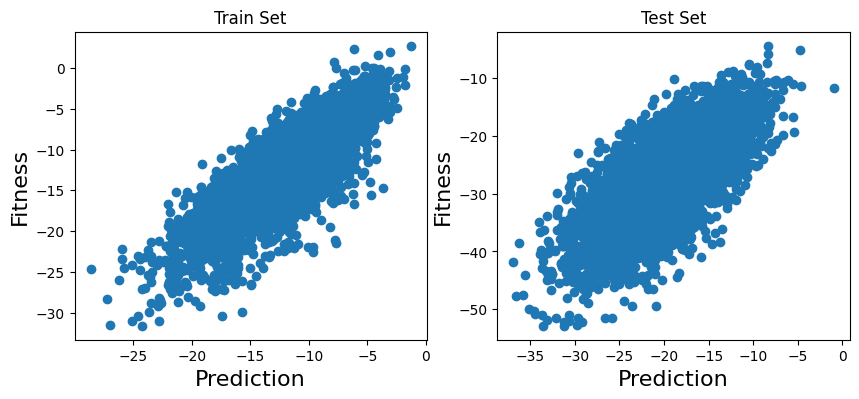

In [475]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.scatter(train_preds, y_train)
ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.set_title('Train Set')

ax = axs[1]
ax.scatter(test_preds, y_test)
ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.set_title('Test Set')

pass

### XGBoost Models

In [453]:
xgb_model = xgb.XGBRegressor(n_estimators=100, gamma=10)

In [454]:
def one_hot(x, k):
    return np.take(np.eye(k), x, axis=0)

def featurize(x):
    return einops.rearrange(one_hot(x, 20), 'b l v -> b (l v)')

In [455]:
train_feat = featurize(x_train)
test_feat = featurize(x_test)

In [456]:
xgb_model = xgb_model.fit(train_feat, y_train)

In [457]:
train_preds = xgb_model.predict(train_feat)
test_preds = xgb_model.predict(test_feat)

In [458]:
print('train')
print('spearman:', scipy.stats.spearmanr(train_preds, y_train).correlation)
print('l2:', np.square(train_preds - y_train).mean())

print()

print('test')
print('spearman:', scipy.stats.spearmanr(test_preds, y_test).correlation)
print('l2:', np.square(test_preds - y_test).mean())

train
spearman: 0.9650746339119174
l2: 3.3402174

test
spearman: 0.6357419155265757
l2: 125.63712


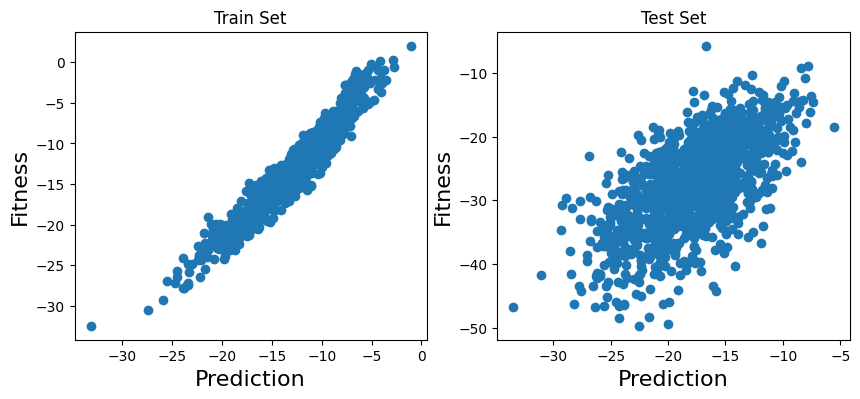

In [459]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.scatter(train_preds, y_train)
ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.set_title('Train Set')

ax = axs[1]
ax.scatter(test_preds, y_test)
ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.set_title('Test Set')

pass

## Example Supervised Modeling

In [ ]:
tokens_train = torch.tensor(x_train, dtype=torch.long).to(device)
tokens_test = torch.tensor(x_test, dtype=torch.long).to(device)

In [351]:
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

/tmp/ipykernel_98016/3577741234.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/tmp/ipykernel_98016/3577741234.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).to(device)


In [352]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

### Example Training Run

In [355]:
losses = []

metrics = collections.defaultdict(list)

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    preds = model.forward(tokens_train)[:, 0]
    loss = torch.nn.SmoothL1Loss(beta=1.0)(preds, y_train)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()

    train_pred = model.forward(tokens_train)[:, 0]
    test_pred =  model.forward(tokens_test)[:, 0]
    
    train_spearman = spearmanr(y_train.to('cpu').detach().numpy(), train_pred.to('cpu').detach().numpy())
    test_spearman = spearmanr(y_test.to('cpu').detach().numpy(), test_pred.to('cpu').detach().numpy())

    metrics['train_spearman'].append(train_spearman.correlation)
    metrics['test_spearman'].append(test_spearman.correlation)

100%|█████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.02it/s]


In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(losses)

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(metrics['train_spearman'], label='test')
ax.plot(metrics['test_spearman'], label='train')

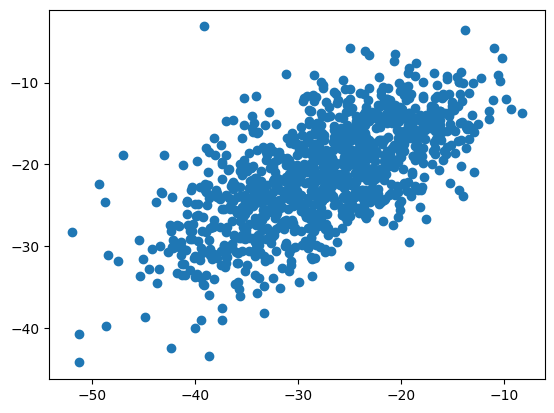

In [361]:
fig, ax = plt.subplots(1, 1)

test_pred = model.forward(tokens_test)[:, 0]
ax.scatter(y_test.to('cpu').detach().numpy(), test_pred.to('cpu').detach().numpy())

In [385]:
df_top = design_batch(model, x_test, iters=100)

average score: 22.4090: 100%|██████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


In [ ]:
df_top

In [ ]:
landscape.evaluate(np.array(df_top.seq.tolist()))

## MLDE

In [446]:
def train_model(df: pd.DataFrame) -> nn.Module:
    df_train = df[df.split == "train"]
    df_test = df[df.split == "test"]
    
    tokens_train = torch.tensor(df_train.seq.tolist(), dtype=torch.long).to(device)
    y_train = torch.tensor(df_train.fitness.values).to(device)

    tokens_test = torch.tensor(df_test.seq.tolist(), dtype=torch.long).to(device)
    y_test = torch.tensor(df_test.fitness.values).to(device)

    # model = ResNet(in_channels=20, num_blocks=3, num_output=1).to(device)
    model = ConvNet(in_channels=20, hidden_sizes=[16, 16], num_output=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

    for i in tqdm(range(1000)):
        optimizer.zero_grad()
        preds = model.forward(tokens_train)[:, 0]
        loss = torch.nn.SmoothL1Loss(beta=1.0)(preds, y_train)

        loss.backward()
        optimizer.step()

        train_pred = model.forward(tokens_train)[:, 0]
        test_pred =  model.forward(tokens_test)[:, 0]
        
        train_spearman = spearmanr(y_train.to('cpu').detach().numpy(), train_pred.to('cpu').detach().numpy())
        test_spearman = spearmanr(y_test.to('cpu').detach().numpy(), test_pred.to('cpu').detach().numpy())
        wandb.log({
            'loss': loss,
            'train_spearman': train_spearman.correlation,
            'test_spearman': test_spearman.correlation,
        })

    return model

In [447]:
def design_batch(model, seqs: np.ndarray, batch_size: int, iters: int = 10):
    df_top = pd.DataFrame({'seq': list(seqs)})
    pbar = tqdm(range(iters))
    for _ in pbar:
        df_top.drop_duplicates('seq')
        tokens = torch.tensor(df_top.seq, dtype=torch.long).to(device)
        df_top['pred'] = model.forward(tokens)[:, 0].cpu().detach().numpy()
        avg = df_top.pred.mean()
        pbar.set_description(f"average score: {avg:.4f}")
        df_top = df_top.sort_values(by='pred', ascending=False).head(100)

        seqs = []
        for seq in df_top.seq:
            muts = sampling.sample_within_hamming_radius(
                seq, 10,
                landscape.vocab_size,
                min_mutations=1,
                max_mutations=3,
            )
            seqs.extend(muts)
        df_top = pd.DataFrame({'seq': seqs})

    tokens = torch.tensor(df_top.seq, dtype=torch.long).to(device)
    df_top['pred'] = model.forward(tokens)[:, 0].cpu().detach().numpy()
    return df_top.sort_values(by='pred', ascending=False).head(batch_size)

In [452]:
def sequence_design(landscape, rounds: int = 10):
    wandb.init(
        project="sequence-design",
        config={
            "learning_rate": 0.02,
        }
    )

    sample = sampling.sample_within_hamming_radius(
        landscape.wildtype_sequence, 96,
        landscape.vocab_size,
        1, 10,
    )
    df = pd.DataFrame({'seq': list(sample), 'fitness': landscape.evaluate(sample)})

    for round in range(rounds):
        print(f'round: {round}')
        df['split'] = random.choices(['train', 'test'], k=df.shape[0], weights=[0.8, 0.2])
        print(f'split sizes: {df.split.value_counts()}')
        model = train_model(df)
        df_design = design_batch(model, df[df.split == "test"].seq, batch_size=96, iters=5)
    
        df_design['fitness'] = landscape.evaluate(np.array(df_design.seq.values.tolist()))
        del df_design['pred']
    
        df = pd.concat([df, df_design], axis=0)

        wandb.log({
            'top10avg': df.sort_values(by='fitness', ascending=False).head(10).fitness.mean(),
            'avg': df.fitness.mean(),
            'round': round,
        })

sequence_design(landscape)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▂▂▂▁▆▃▁▁█▃▃▃▆▃▃▂▄▃▃▃▃▃▃▃▄▄▄▄▅▅▄▄▆▆▆▅▆▆▆▅
test_spearman,▃▆▅▅▁███▅▅▅▇▄▅▇▇▅▆▇▇▄▅▅▅▃▃▃▄▄▃▃▃▆▆▆▆▂▂▂▂
train_spearman,▅▆▆▇▁███▅▅▆▇▄▅▇▇▄▅▆▇▄▆▅▅▄▃▃▄▄▃▃▃▅▅▅▄▃▃▃▃
loss,25.19537
test_spearman,0.02519
train_spearman,0.14434


round: 0
split sizes: split
train    73
test     23
Name: count, dtype: int64


average score: -1.2338: 100%|██████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


round: 1
split sizes: split
train    149
test      43
Name: count, dtype: int64


average score: -1.7578: 100%|██████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


round: 2
split sizes: split
train    235
test      53
Name: count, dtype: int64


average score: -3.1829: 100%|██████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


round: 3
split sizes: split
train    309
test      75
Name: count, dtype: int64


average score: -31.0345: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


round: 4
split sizes: split
train    377
test     103
Name: count, dtype: int64


average score: -35.4471: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


round: 5
split sizes: split
train    459
test     117
Name: count, dtype: int64


average score: -37.8676: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


round: 6
split sizes: split
train    545
test     127
Name: count, dtype: int64


average score: -39.3906: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


round: 7
split sizes: split
train    606
test     162
Name: count, dtype: int64


average score: -40.0653: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


round: 8
split sizes: split
train    698
test     166
Name: count, dtype: int64


average score: -46.2199: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


round: 9
split sizes: split
train    769
test     191
Name: count, dtype: int64


average score: -48.5823: 100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]
